In [141]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('SD: ', scores.std())

In [3]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


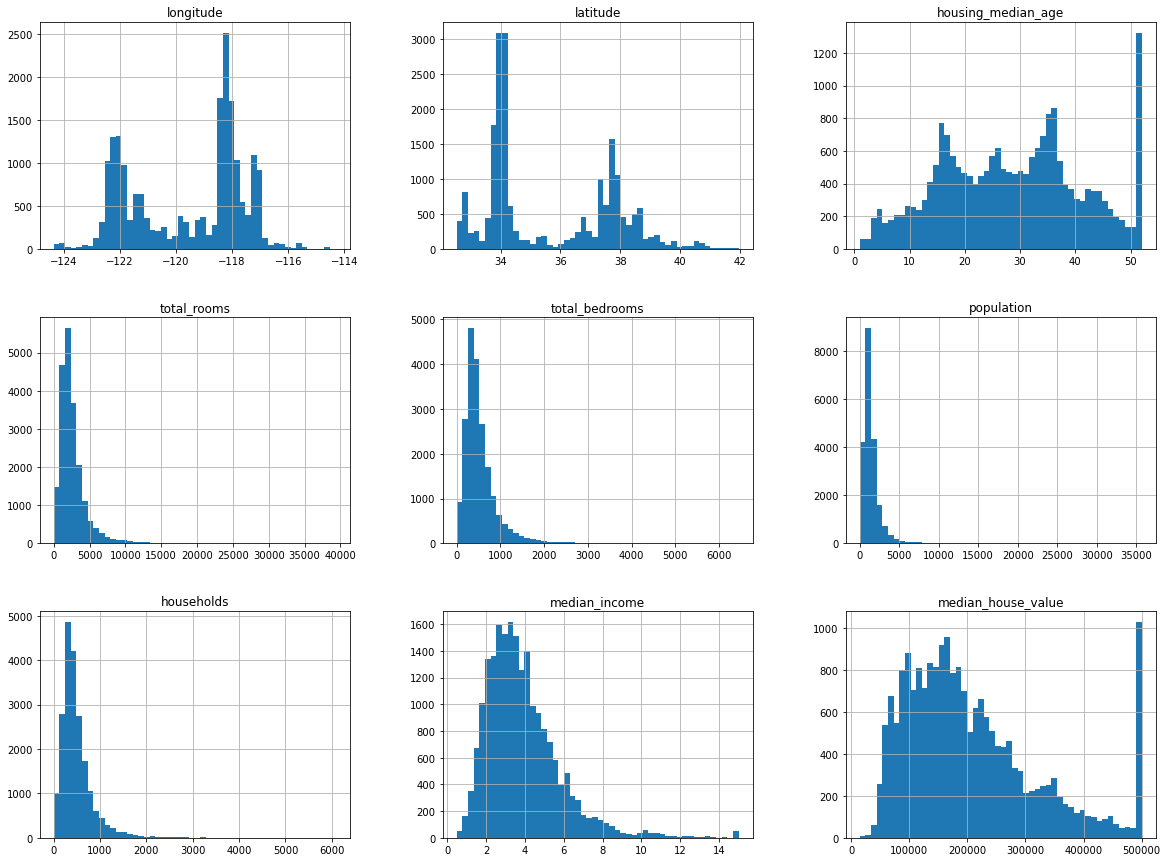

In [7]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [23]:
#using my function
train_set, test_set = split_train_test(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [24]:
#using sklearn function
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

<AxesSubplot:>

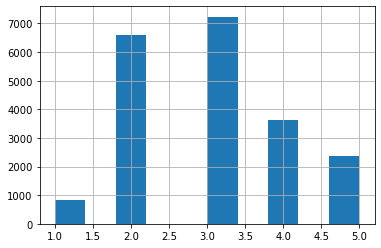

In [25]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0,1.5,3.0,4.5,6.0, np.inf], labels=[1,2,3,4,5])
housing.income_cat.hist()

In [26]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2 , random_state=42)
for train_idx, test_idx in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]

In [27]:
strat_test_set.income_cat.value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [28]:
#remove the income_cat attribute
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1,inplace=True)

In [29]:
#making a copy of the original data to work with it
housing = strat_train_set.copy()

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

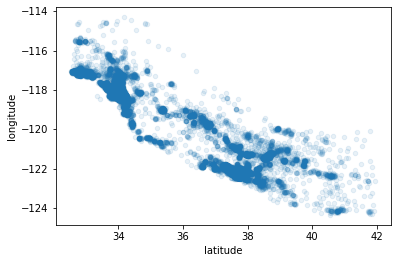

In [35]:
#visualizing geographical data
housing.plot(kind='scatter', x='latitude', y='longitude', alpha=0.1)

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

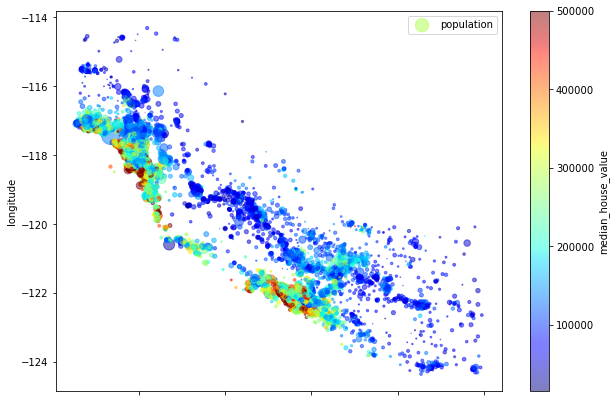

In [38]:
housing.plot(kind='scatter', x='latitude', y='longitude', alpha=0.5, s=housing['population']/100, 
             label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'),colorbar=True)

In [41]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

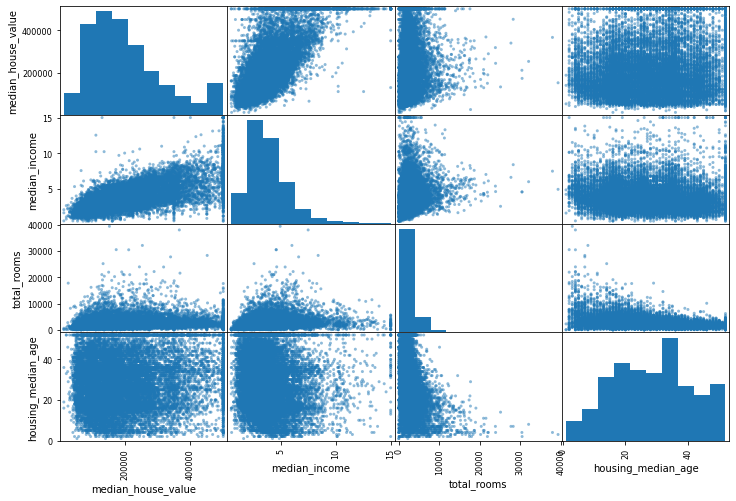

In [45]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes],figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

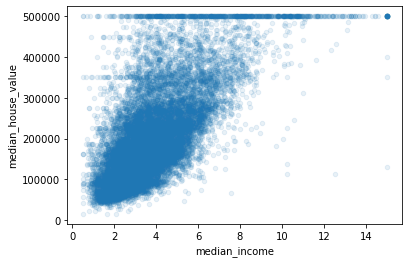

In [46]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [47]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [48]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [49]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set.median_house_value.copy()

In [51]:
#filling missing values with median
imputer = SimpleImputer(strategy='median')

#median can only be appllied to the numerical attributes
housing_num = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_num)
imputer.statistics_ , housing.median().values

C:\Users\noura\AppData\Local\Temp/ipykernel_10648/1447234423.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  imputer.statistics_ , housing.median().values


(array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]),
 array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]))

In [52]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

Handling Categorical Attribute 'ocean_proximity'

In [61]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [66]:
ord_encoder = OrdinalEncoder()
housing_cat_encoded = ord_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10], ord_encoder.categories_

(array([[0.],
        [0.],
        [4.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]]),
 [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)])

In [69]:
one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [71]:
#converting sparse matrix into a 2D array
housing_cat_1hot.toarray(), one_hot_encoder.categories_

(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]]),
 [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)])

In [82]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self,X, y=None):
        return self
    
    def transform(self,X):
        rooms_per_household = X[:, rooms_ix]/X[:,households_ix]
        population_per_household = X[:, population_ix]/X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombineAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [92]:
nums_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),('attribs_adder', CombineAttributesAdder()),('std_scaler', StandardScaler()),])
housing_num_tr = nums_pipeline.fit_transform(housing_num)

In [95]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([('num', nums_pipeline, num_attribs),('cat', OneHotEncoder(), cat_attribs)])
housing_prepared = full_pipeline.fit_transform(housing)

Training and Evaluating on the Training Set

In [97]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [99]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('predictions: ', lin_reg.predict(some_data_prepared))
print('labels: ', list(some_labels))

predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [102]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [108]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [118]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

display_scores(tree_rmse_scores)

Scores: [68433.76023122 67660.42046683 70573.97065932 68516.93649275
 69507.32180177 75998.09668338 71120.71995176 70650.41490857
 77319.38778368 71484.42290651]
Mean: 71126.54518857837
SD:  3023.9132883989496


In [119]:
lin_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [68885.11216603 66179.59219005 70850.99640354 68890.34161137
 70562.2369251  74130.21784088 71882.33033378 69904.88189204
 78909.31052331 70115.61249804]
Mean: 71031.06323841512
SD:  3278.403853742414


In [121]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18705.86773254108

In [122]:
forest_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [67708.6393171  67847.31426307 71306.18894504 69582.28486626
 70702.39661609 74851.47559717 70507.74720832 70239.69206865
 76813.31162346 70694.17437137]
Mean: 71025.32248765214
SD:  2692.594890533509


In [126]:
param_grid = [{'n_estimators':[3,10,30],'max_features':[2,4,6,8]}, 
             {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [131]:
grid_search.best_params_, grid_search.best_estimator_

({'max_features': 8, 'n_estimators': 30},
 RandomForestRegressor(max_features=8, n_estimators=30))

In [134]:
cvres = grid_search.cv_results_
for mean_score , param in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), param)

63181.341586907736 {'max_features': 2, 'n_estimators': 3}
55645.944711676886 {'max_features': 2, 'n_estimators': 10}
52848.906199262565 {'max_features': 2, 'n_estimators': 30}
60153.44554773519 {'max_features': 4, 'n_estimators': 3}
52527.78001114256 {'max_features': 4, 'n_estimators': 10}
50510.73485966563 {'max_features': 4, 'n_estimators': 30}
57748.90193196314 {'max_features': 6, 'n_estimators': 3}
51779.740059079915 {'max_features': 6, 'n_estimators': 10}
50164.674154151835 {'max_features': 6, 'n_estimators': 30}
59608.29887640088 {'max_features': 8, 'n_estimators': 3}
51477.611329475956 {'max_features': 8, 'n_estimators': 10}
49947.78622023469 {'max_features': 8, 'n_estimators': 30}
62521.63354997177 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54723.83418490139 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59861.98238634936 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52899.34686800692 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [135]:
feature_imp = grid_search.best_estimator_.feature_importances_
feature_imp

array([7.02270347e-02, 6.81334191e-02, 4.31852339e-02, 1.47037750e-02,
       1.54092191e-02, 1.57454079e-02, 1.47303639e-02, 3.32313574e-01,
       6.04354055e-02, 1.12318883e-01, 8.46375840e-02, 9.23381777e-03,
       1.52186098e-01, 5.15711690e-05, 2.41236766e-03, 4.27624598e-03])

In [137]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_imp, attributes), reverse=True)

[(0.3323135736807263, 'median_income'),
 (0.152186097503476, 'INLAND'),
 (0.11231888315300229, 'pop_per_hhold'),
 (0.08463758398400137, 'bedrooms_per_room'),
 (0.07022703467983664, 'longitude'),
 (0.06813341913816859, 'latitude'),
 (0.06043540547373154, 'rooms_per_hhold'),
 (0.0431852339162699, 'housing_median_age'),
 (0.01574540788331618, 'population'),
 (0.015409219093680232, 'total_bedrooms'),
 (0.014730363941184065, 'households'),
 (0.014703774978865016, 'total_rooms'),
 (0.009233817770995231, '<1H OCEAN'),
 (0.004276245978297578, 'NEAR OCEAN'),
 (0.0024123676554637487, 'NEAR BAY'),
 (5.1571168985439545e-05, 'ISLAND')]

In [140]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47795.014576598805

Computing the 95% confindence interval for the generalization error.

In [142]:
confidence = .95
sqr_error = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(sqr_error) - 1, loc=sqr_error.mean(), scale=stats.sem(sqr_error)))

array([45836.99611188, 49675.91593714])